# Sujet 2 : GCL RANDU

Moyano Axel 

Bonnassie Enzo

Grp 2A



On veut tester le GCL RANDU dont les caractéristiques sont les suivantes :

$
x_{n+1} \equiv 65539 \, x_n \pmod{2^{31}}, \quad x_0 = 12345
$

## À partir de ce GCL générer une suite de nombre dans l’intervalle [0,1].

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [48]:
def normaliser(liste):
    minimum = min(liste)
    maximum = max(liste)

    newlist = []
    for i in liste :
        newlist.append((i - minimum) / (maximum - minimum))
    return newlist

def CGL_RANDU(nb_valeurs) :
    xn = 12345
    liste_valeurs = []
    
    for i in range(nb_valeurs) :
        xn1 = (65539 * xn)% (2**31)

        liste_valeurs.append(xn1)
        xn = xn1

    return normaliser(liste_valeurs)

def afficher_histogramme(liste) :
    plt.hist(liste, bins=5, edgecolor='black')
    plt.title("Histogramme des valeurs")
    plt.xlabel("Valeur")
    plt.ylabel("Fréquence")
    plt.show()
    

[0.3760847653561407, 0.25852465564691807, 0.1691756301589908, 0.6911224646144312, 0.5824918497109879, 0.2887527139756533, 0.5151066464514931, 0.47242961189711224, 0.20140843780198497, 0.9816011297343643, 0.013042146129923151, 0.32442578295101376, 0.7986263287489499, 0.8413768721467509, 0.8745280713795636, 0.6886803761962292, 0.2863466247577679, 0.5560865855338664, 0.7399640493523206, 0.4266823980350171, 0.9365481667925394, 0.7485983646522578, 0.08767369677715654, 0.8470135470596568, 0.22912931930513425, 0.8100106405609319, 0.7562377030747011, 0.2612342506394258, 0.8085096116744255, 0.4582871477470386, 0.5092666041657243, 0.9338058797537476, 1.0, 0.6096508794558778, 0.7051487122454467, 0.746824942852529, 0.13740183138890255, 0.15022993817083435, 0.6564405182507743, 0.5449113994224549, 0.3754075295173667, 0.36214637954171314, 0.797001096076727, 0.4921401067971191, 0.8159609988454943, 0.4470691908679277, 0.374896378351439, 0.2285461367800337, 0.0, 0.9569885662193034]


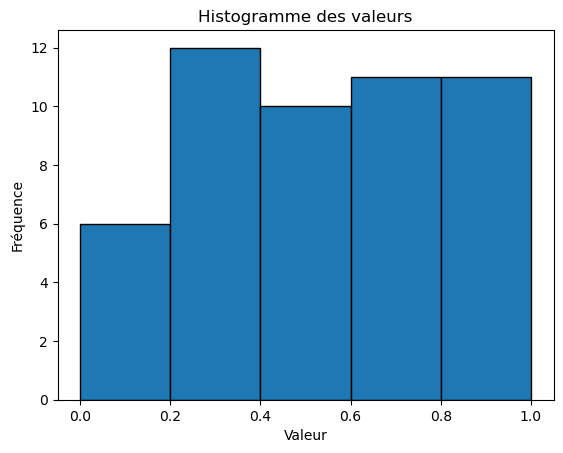

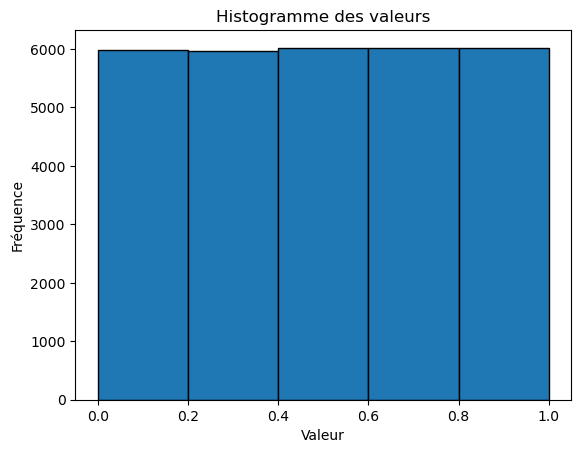

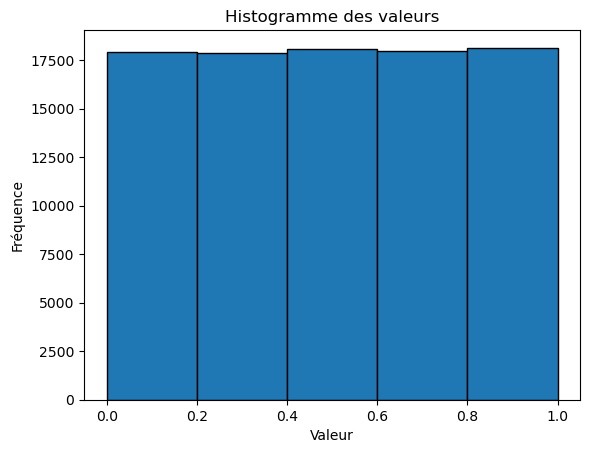

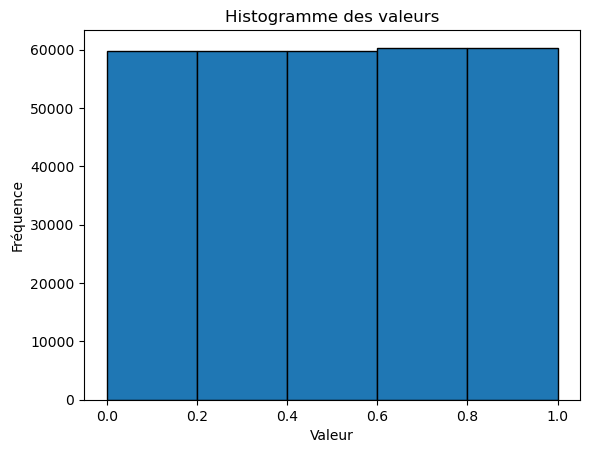

In [49]:
liste = CGL_RANDU(50)
liste2 = CGL_RANDU(30000)
liste3 = CGL_RANDU(90000)
liste4 = CGL_RANDU(300000)
print(liste)

afficher_histogramme(liste)
afficher_histogramme(liste2)
afficher_histogramme(liste3)
afficher_histogramme(liste4)


## Test du chi2

In [50]:
from scipy.stats import chisquare


def test_chi2(observed):
    # Nombre de classes (plus il y a de données, plus on peut en mettre)
    nb_classes = 10

    # Regroupement en classes (histogramme)
    counts, _ = np.histogram(observed, bins=nb_classes, range=(0, 1))

    # Distribution uniforme attendue
    expected = np.full(nb_classes, len(observed) / nb_classes)

    # Calcul du test du chi²
    chi2_stat, p_value = chisquare(f_obs=counts, f_exp=expected)

    # Seuil de confiance à 1 %
    alpha = 0.01

    # Affichage du résultat
    print(f"Statistique du chi² : {chi2_stat:.4f}")
    print(f"p-value : {p_value:.6f}")
    print("Résultat :", "Vrai (H0 acceptée)" if p_value > alpha else "Faux (H0 rejetée)")

# Exemple d'utilisation :

In [51]:
test_chi2(liste2)

Statistique du chi² : 6.9053
p-value : 0.646975
Résultat : Vrai (H0 acceptée)
